In [23]:
import pandas as pd    
import numpy as np  
import matplotlib.pyplot as plt     
import seaborn as sns
import sqlalchemy                                                          
from sqlalchemy.ext.automap import automap_base


In [24]:
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, desc
import datetime

In [25]:
trip_start_date = '2018-08-03'                                              
trip_end_date = '2018-08-13'

In [26]:
engine = create_engine("sqlite:///hawaii.sqlite") 
 

In [27]:
Base = automap_base()                                                        
Base.prepare(engine, reflect=True) 

In [28]:
conn = engine.connect()                                                      
inspector = inspect(engine) 

In [29]:
Base.classes.keys()   

['measurement', 'station']

In [30]:
Measurement = Base.classes.measurement                                       
Station = Base.classes.station

In [31]:
session = Session(engine) 

In [32]:
precip_analysis = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= "2016-08-20").\
    filter(Measurement.date <= "2017-08-20").all()

In [33]:
precip_df = pd.DataFrame(precip_analysis)

In [34]:
precip_df['date'] = pd.to_datetime(precip_df['date'])

In [35]:
precip_df = precip_df.set_index('date')                                      
precip_df.rename(columns = {'prcp': 'precipitation'}, inplace=True)          
precip_df.head()

,precipitation
date,
2016-08-20,0.00
2016-08-21,0.12
2016-08-22,0.40
2016-08-23,0.00
2016-08-24,0.08


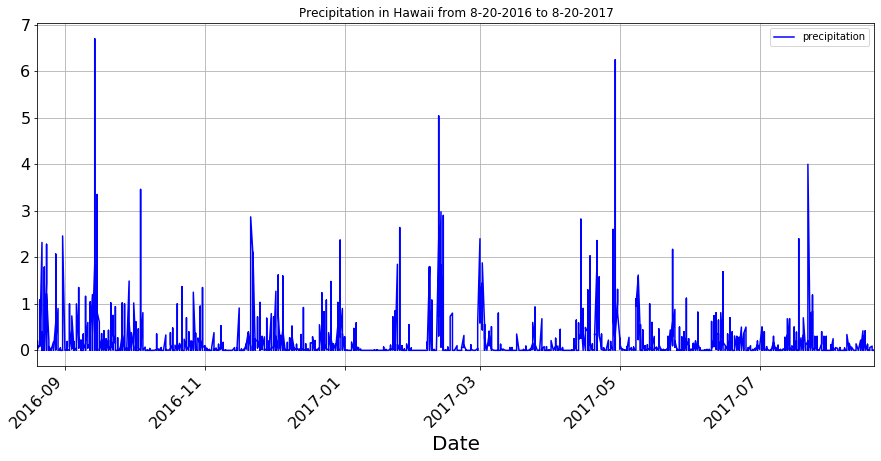

In [36]:
precip_df.plot(figsize=(15, 7),                                              
               sort_columns=True, 
               rot=45, 
               use_index=True, 
               title='Precipitation in Hawaii from 8-20-2016 to 8-20-2017', 
               legend=True,
               fontsize=16,
               grid=True,
               color='Blue'
              )

plt.xlabel('Date', fontsize=20)
plt.show()

In [37]:
precip_df.describe()  

,precipitation
count,4474.000000
mean,0.162852
std,0.444859
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


In [38]:
station_count = session.query(Station.id).count()                           
print(f'There are {station_count} weather stations in Hawaii.')

There are 18 weather stations in Hawaii.


In [39]:
station_activity = session.query(Measurement.station, Station.name, func.count(Measurement.tobs)).\
filter(Measurement.station == Station.station).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()

In [40]:
station_activity 

[('USC00519281', 'WAIHEE 837.5, HI US', 11088),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 10896),
 ('USC00513117', 'KANEOHE 838.1, HI US', 10836),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 10676),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 10448),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 8808),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 7916),
 ('USC00517948', 'PEARL CITY, HI US', 5488),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 2044)]

In [41]:
station_activity[0]

('USC00519281', 'WAIHEE 837.5, HI US', 11088)

In [42]:
most_active_station_tobs = session.query(Measurement.tobs).\
filter(Measurement.station == most_active_station, Measurement.station == Station.station,\
       Measurement.date >="2016-08-24", Measurement.date <="2017-08-23").all()

In [43]:
for row in reversed(station_activity):                                      
    most_active_station=row.station
    most_active_name=str(row.name)

In [44]:
temperatures = [temp[0] for temp in most_active_station_tobs] 

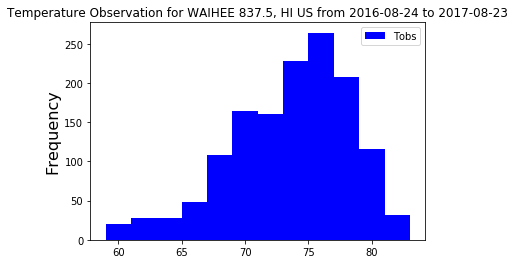

In [45]:
plt.hist(temperatures, bins=12, color='Blue')                         
plt.title("Temperature Observation for %s from 2016-08-24 to 2017-08-23" % (most_active_name))
plt.ylabel('Frequency', fontsize=16)
labels = ['Tobs']
plt.legend(labels)
plt.show()

In [46]:
def calc_temps(start, end):
    """ function calc_temps
        parameters: start (string), end (string)
        returns: list
        extracts data using a SQL Alchemy query and returns list
        of avg temperature, lowest temperature, highest temperature
    """
    temp_list = []
    query = session.query(Measurement.tobs).filter(Measurement.date>=start, Measurement.date<=end).all()
    temperatures = [temp[0] for temp in query]
    temp_list.append(np.mean(temperatures))
    temp_list.append(min(temperatures))
    temp_list.append(max(temperatures))
    
    return temp_list

In [47]:
def get_prev_year_date(target):
    """ function get_prev_year_date
        parameters: target (string)
        returns: string
        disassembles string and subtracts 1 from year portion
        returns parameter input on error
    """
    try:
        xl = target.split('-')
        xc = (str(int(xl[0])-1)) + '-' + xl[1] + '-' + xl[2]
        return xc
    except:
        return target

In [48]:
start_conv = get_prev_year_date(trip_start_date)                            
end_conv = get_prev_year_date(trip_end_date)

In [49]:
temp_list = calc_temps(start_conv, end_conv)  
temp_list

[79.53488372093024, 71, 84]

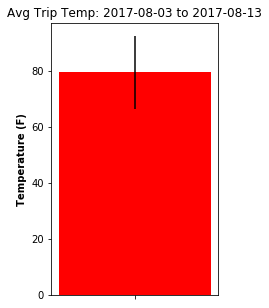

In [50]:
plt.figure(figsize=(3,5))                                                  
plt.bar(1, temp_list[0], yerr=(temp_list[2] - temp_list[1]), tick_label='', color='red')
plt.ylabel("Temperature (F)", weight="bold")
plt.title("Avg Trip Temp: %s to %s" % (start_conv, end_conv))
plt.show()
   

In [51]:
def get_pdate(target):
    """ function get_pdate 
        parameters: target (string)
        returns: string
        splits input string in date format and returns
        partial date in %m-%d format.
    """
    target_parse = target.split('-')
    return target_parse[1] + '-' + target_parse[2]

In [52]:
def daily_normals(target_date):
    """ function daily_normals
        parameters: target_date (string)
        returns: list
        extracts data using a SQL Alchemy query and returns list
        of averages of min, avg, and max temperature.
    """
    temp_list = []
    query = session.query(Measurement.tobs).filter(Measurement.date.like('%' + get_pdate(target_date))).all()
    temperatures = [temp[0] for temp in query]
    temp_list.append(target_date)
    temp_list.append(min(temperatures))
    temp_list.append(np.mean(temperatures))
    temp_list.append(max(temperatures))
    
    return temp_list

In [53]:
def get_date_list(start_date, end_date):
    """ function get_date_list
        parameters: start_date (string), end_date (string)
        returns: list
        extracts all dates between start_date and end_date
        and returns dates in %Y-%m-%d format.
    """
    date_list = []
    
    tsds = start_date.split('-')
    teds = end_date.split('-')
    
    begin = datetime.date(int(tsds[0]), int(tsds[1]), int(tsds[2]))
    end = datetime.date(int(teds[0]), int(teds[1]), int(teds[2]))

    next_day = begin
    while True:
        if next_day > end:
            break
        date_list.append(str(next_day))
        next_day += datetime.timedelta(days=1)
    
    return date_list

In [54]:
target_date_list = get_date_list(start_conv, end_conv)  

In [55]:
data_list = []                                                               
for item in target_date_list:
    data_list.append(daily_normals(item))

In [56]:
daily_normals_df = pd.DataFrame(data_list, columns=['date','tmin', 'tavg', 'tmax'])
daily_normals_df = daily_normals_df.set_index('date') 

In [57]:
daily_normals_df

,tmin,tavg,tmax
date,,,
2017-08-03,70,76.611111,85
2017-08-04,69,76.711538,84
2017-08-05,69,76.148148,82
2017-08-06,67,76.250000,83
2017-08-07,71,77.156863,83
2017-08-08,68,76.557692,83
2017-08-09,69,75.980392,81
2017-08-10,65,76.420000,83
2017-08-11,67,75.981132,82


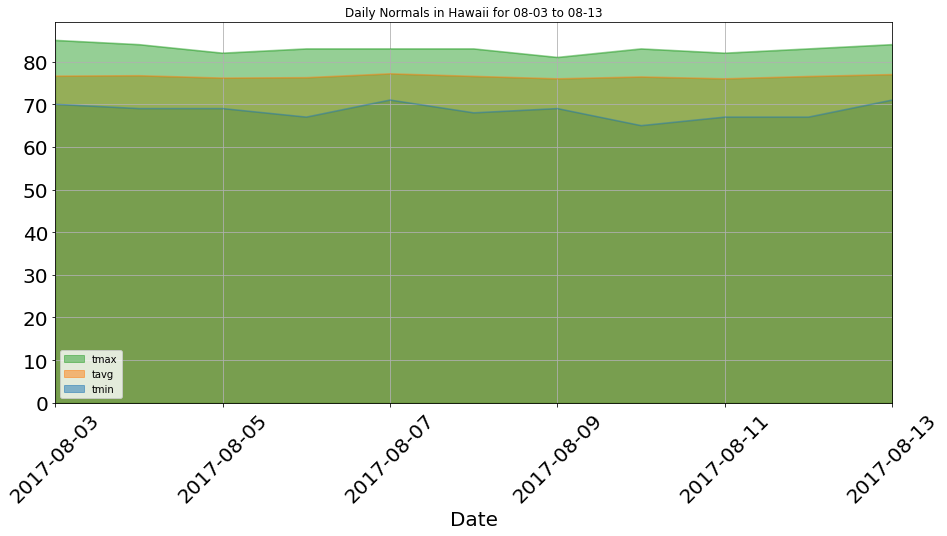

In [58]:
daily_normals_df.plot(figsize=(15, 7),                                       # plots the data
                      kind='area',
                      sort_columns=True, 
                      rot=45, 
                      use_index=True, 
                      title='Daily Normals in Hawaii for %s to %s' % (get_pdate(start_conv), get_pdate(end_conv)), 
                      stacked=False,
                      legend='reverse',
                      fontsize=20,
                      grid=True,
                     ) 

plt.xlabel('Date', fontsize=20)
plt.show()